In [1]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, diffpair_cc, cm_pmos, spice_sim
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import paretoset as pareto

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

In [21]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

lut_file = "../../LUTs/gf_LUT_03v3.npy"
lut_w = 20e-6

## Electrical parameters

Vout = 1.2                                      # LDO output voltage
Vin = 1.8                                       # LDO supply voltage
Vref = 0.9                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 10e-6 # considering the two branches of differential pair
I_amp = 20e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

,Value
Vout,1.200000e+00
Vin,1.800000e+00
Vref,9.000000e-01
IL,5.000000e-03
CL,5.000000e-13
RL,2.400000e+02
Iq_max,1.000000e-04
Ib_pt,7.500000e-05
R1,4.000000e+03
R2,1.200000e+04


In [22]:
Vota = 0.688

In [136]:
LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"), 
        Symbol("W_diff_m2"), Symbol("L_diff_m2"), 
        Symbol("W_aload"), Symbol("L_aload"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"), 
        Symbol("W_diff_m2"), Symbol("L_diff_m2"), 
        Symbol("W_aload"), Symbol("L_aload"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Il": I_amp},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

In [24]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*1.8)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

In [25]:
gain_OTA = Test()
gain_OTA.tf = ("vout", "vpos")
gain_OTA.name = "gain_OTA"
gain_OTA.netlist = "ota_1stage"
gain_OTA.parametros = {
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("gdiff_2"): Symbol("gdiff_1"), 
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("V1"): 0,
    Symbol("V_b"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0,
    Symbol("Cl"): 1e-1}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "ota_1stage_rout"
rout_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "ota_1stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

In [26]:
pt = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): pt_df['cgd'].values,
    Symbol("Cin_pt"): pt_df['cgg'].values+pt_df["cgd"].values*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"].values/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-1.8, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        +pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        *pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0
Values of Vgs_pt when there is no load:  [-0.74235348 -0.75078729 -0.74468328 -0.74106026 -0.73915898]
length
vgs
0


In [31]:
pt.W

array([[0.00090357],
       [0.00220074],
       [0.00467678],
       [0.00969476],
       [0.01977127]])

In [81]:
## DIFF PAIR PRIMITIVE #####################################################################

sweep_size_dp = 3
vin_dp = OTA_macro.electrical_parameters["Vref"]
vout_dp = OTA_macro.electrical_parameters["Vout"]
vs_dp = np.linspace(0.1, vin_dp-0.1, sweep_size_dp)
vcp_dp = np.linspace(vin_dp, vout_dp-0.1, sweep_size_dp)

diffpair_primitive = diffpair_cc(vcp_dp, vs_dp, vin_dp, vout_dp, I_amp/2, sweep_size_dp, lengths_nmos, vout_dp + 0.5, lut_file, lut_w)
diffpair_primitive_df = diffpair_primitive.build()     
diffpair_primitive_mask = ~diffpair_primitive_df.isna().any(axis=1)   
#diffpair_primitive_df = diffpair_primitive_df.dropna()
#diffpair_primitive_mask = (diffpair_primitive_df["width_m1"]>1e-6) & (diffpair_primitive_df["width_m2"]>1e-6)
diffpair_primitive_df = diffpair_primitive_df[diffpair_primitive_mask]

diffpair_primitive.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df["Ro"].values, 
                                 Symbol("gdiff_1"): diffpair_primitive_df["gm"].values,
                                 Symbol("vbias"): diffpair_primitive_df["vbias"].values,
                                 Symbol("vs_diff"): diffpair_primitive_df["vs"].values}

diffpair_primitive.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                                Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      lut_file=lut_file,
                      lut_w = lut_w,
                      netlist='pmos_cm ', 
                      type='pmos', 
                      inputs={'vds_lut': OTA_macro.electrical_parameters["Vout"]-OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': OTA_macro.electrical_parameters["Vout"]-OTA_macro.electrical_parameters["Vdd"], 
                              'il': OTA_macro.electrical_parameters["Il"]/2,
                              'length': lengths_nmos, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("gaload_1"): np.asarray(ota_cm_pmos.gm).flatten()}
ota_cm_pmos.outputs = {Symbol("W_aload"): np.asarray(ota_cm_pmos.W).flatten(),
                       Symbol("L_aload"): np.asarray(ota_cm_pmos.L).flatten()}

#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}

for vds_cs in vs_dp:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 1.8, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

vds
vgs
1
M1 jd:  [[3.99425947e+00 3.09608127e-03 1.76873920e-07 3.91025099e+00
  2.93284323e-03            nan 3.81803010e+00 2.72912923e-03
             nan]
 [1.84616068e+00 1.22275138e-03 8.01316842e-08 1.83328858e+00
  1.19958250e-03            nan 1.81860579e+00 1.16860448e-03
             nan]
 [1.05155676e+00 8.99558837e-04 6.30052265e-08 1.04719922e+00
  8.88403132e-04            nan 1.04231504e+00 8.74671261e-04
             nan]
 [5.65947224e-01 6.53447105e-04 4.91004870e-08 5.64444287e-01
  6.47951968e-04            nan 5.62764465e-01 6.41361656e-04
             nan]
 [2.92208250e-01 3.94165553e-04 3.24695222e-08 2.91671471e-01
  3.91714123e-04            nan 2.91081482e-01 3.88863037e-04
             nan]]
M1 gmid:  [[11.08291466 26.58141348 26.98508699 11.14634855 26.59393681         nan
  11.20290812 26.60495937         nan]
 [11.73785728 26.6802703  25.93700198 11.75733599 26.68201748         nan
  11.7734517  26.68320545         nan]
 [11.02741766 26.40809821 25.413630

In [82]:
vout_2stage_wc = 1.05

In [83]:
diffpair_primitive_wc = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_2stage_wc, 
    I_amp/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    lut_file,
    lut_w)

diffpair_primitive_df_wc =  diffpair_primitive_wc.build()

diffpair_primitive_wc.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df_wc["Ro"].values[diffpair_primitive_mask], 
                                 Symbol("gdiff_1"): diffpair_primitive_df_wc["gm"].values[diffpair_primitive_mask],
                                 Symbol("vbias"): diffpair_primitive_df_wc["vbias"].values[diffpair_primitive_mask],
                                 Symbol("vs_diff"): diffpair_primitive_df_wc["vs"].values[diffpair_primitive_mask]}
diffpair_primitive_wc.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                                 Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                                 Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                                 Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

ota_cm_pmos_wc = cm_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={'vds_lut': OTA_macro.electrical_parameters["Vout"]-OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': vout_2stage_wc-OTA_macro.electrical_parameters["Vdd"], 
                              'il': OTA_macro.electrical_parameters["Il"]/2,
                              'length': lengths_nmos, 
                              '2d_var': ['length', 'vgs']})

ota_cm_pmos_wc.build()

ota_cm_pmos_wc.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos_wc.Ro).flatten(),
                          Symbol("gaload_1"): np.asarray(ota_cm_pmos_wc.gm).flatten()}
ota_cm_pmos_wc.outputs = {Symbol("W_aload"): np.asarray(ota_cm_pmos.W).flatten(),
                       Symbol("L_aload"): np.asarray(ota_cm_pmos.L).flatten()}

vds
vgs
1
M1 jd:  [[3.99425947e+00 3.09608127e-03 1.76873920e-07 3.91025099e+00
  2.93284323e-03            nan 3.81803010e+00 2.72912923e-03
             nan]
 [1.84616068e+00 1.22275138e-03 8.01316842e-08 1.83328858e+00
  1.19958250e-03            nan 1.81860579e+00 1.16860448e-03
             nan]
 [1.05155676e+00 8.99558837e-04 6.30052265e-08 1.04719922e+00
  8.88403132e-04            nan 1.04231504e+00 8.74671261e-04
             nan]
 [5.65947224e-01 6.53447105e-04 4.91004870e-08 5.64444287e-01
  6.47951968e-04            nan 5.62764465e-01 6.41361656e-04
             nan]
 [2.92208250e-01 3.94165553e-04 3.24695222e-08 2.91671471e-01
  3.91714123e-04            nan 2.91081482e-01 3.88863037e-04
             nan]]
M1 gmid:  [[11.08291466 26.58141348 26.98508699 11.14634855 26.59393681         nan
  11.20290812 26.60495937         nan]
 [11.73785728 26.6802703  25.93700198 11.75733599 26.68201748         nan
  11.7734517  26.68320545         nan]
 [11.02741766 26.40809821 25.413630

In [103]:
OTA_macro.ext_mask = None

OTA_macro.primitives = [diffpair_primitive_wc, ota_cm_pmos_wc, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, ota_df_wc_mask = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  ota_1stage
Netlist:  ota_1stage
Running MNA... 
MNA of gain_OTA took: 0.061934709548950195
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
MNA of rout_OTA took: 0.04820728302001953
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
MNA of gm_OTA took: 0.04612016677856445
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_

In [104]:
OTA_macro.ext_mask = ota_df_wc_mask

OTA_macro.primitives = [diffpair_primitive, ota_cm_pmos, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  ota_1stage
Netlist:  ota_1stage
Running MNA... 
MNA of gain_OTA took: 0.05631709098815918
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
MNA of rout_OTA took: 0.04815101623535156
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
MNA of gm_OTA took: 0.049739837646484375
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_

In [112]:
ota_df

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,gcs,Rcs,vs_cs,vgs_cs,...,W_diff_m1,L_diff_m1,W_diff_m2,L_diff_m2,W_aload,L_aload,W_cs,L_cs,area,gain
0,1.353721e+07,0.000112,0.888,0.10,1.520331e+06,0.000052,0.000540,4.200447e+04,0.10,0.10,...,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,113.074896,4.000000e-07,113.301118,43.652103
1,1.353721e+07,0.000112,0.888,0.10,1.520331e+06,0.000052,0.000552,4.072225e+04,0.10,0.30,...,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,0.452432,4.000000e-07,0.678655,43.652250
2,1.353721e+07,0.000112,0.888,0.10,1.520331e+06,0.000052,0.000513,4.049815e+04,0.10,0.50,...,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,0.002048,4.000000e-07,0.228271,43.652277
3,1.353721e+07,0.000112,0.888,0.10,1.520331e+06,0.000052,0.000330,2.045903e+04,0.10,0.70,...,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,0.000025,4.000000e-07,0.226247,43.656598
4,1.353721e+07,0.000112,0.888,0.10,1.520331e+06,0.000052,0.000519,1.034274e+05,0.10,0.10,...,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,249.589163,8.000000e-07,249.815386,43.649141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34970,2.117571e+08,0.000258,1.188,0.45,2.893824e+07,0.000054,0.000546,1.306720e+06,0.45,0.25,...,0.025716,6.400000e-06,0.000739,6.400000e-06,0.000039,6.400000e-06,11.204326,6.400000e-06,11.230845,76.358872
34971,2.117571e+08,0.000258,1.188,0.45,2.893824e+07,0.000054,0.000517,1.306722e+06,0.45,0.45,...,0.025716,6.400000e-06,0.000739,6.400000e-06,0.000039,6.400000e-06,0.050740,6.400000e-06,0.077259,76.358872
34972,2.117571e+08,0.000258,1.188,0.45,2.893824e+07,0.000054,0.000363,2.098557e+06,0.45,0.65,...,0.025716,6.400000e-06,0.000739,6.400000e-06,0.000039,6.400000e-06,0.000547,6.400000e-06,0.027066,76.358870
34973,2.117571e+08,0.000258,1.188,0.45,2.893824e+07,0.000054,0.000169,3.649888e+06,0.45,0.85,...,0.025716,6.400000e-06,0.000739,6.400000e-06,0.000039,6.400000e-06,0.000043,6.400000e-06,0.026562,76.358869


In [111]:
ota_df_wc

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,gcs,Rcs,vs_cs,vgs_cs,...,gm_OTA,W_diff_m1,L_diff_m1,W_diff_m2,L_diff_m2,W_aload,L_aload,W_cs,L_cs,area
0,5.023124e+07,0.000112,0.888,0.10,8.423416e+05,0.000201,0.000540,4.200447e+04,0.10,0.10,...,0.000112,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,113.074896,4.000000e-07,113.301118
1,5.023124e+07,0.000112,0.888,0.10,8.423416e+05,0.000201,0.000552,4.072225e+04,0.10,0.30,...,0.000112,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,0.452432,4.000000e-07,0.678655
2,5.023124e+07,0.000112,0.888,0.10,8.423416e+05,0.000201,0.000513,4.049815e+04,0.10,0.50,...,0.000112,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,0.002048,4.000000e-07,0.228271
3,5.023124e+07,0.000112,0.888,0.10,8.423416e+05,0.000201,0.000330,2.045903e+04,0.10,0.70,...,0.000112,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,0.000025,4.000000e-07,0.226247
4,5.023124e+07,0.000112,0.888,0.10,8.423416e+05,0.000201,0.000519,1.034274e+05,0.10,0.10,...,0.000112,0.000003,4.000000e-07,0.226216,4.000000e-07,0.000002,4.000000e-07,249.589163,8.000000e-07,249.815386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34970,1.126652e+09,0.000258,1.188,0.45,1.722259e+07,0.000199,0.000546,1.306720e+06,0.45,0.25,...,0.000258,0.025716,6.400000e-06,0.000739,6.400000e-06,0.000039,6.400000e-06,11.204326,6.400000e-06,11.230845
34971,1.126652e+09,0.000258,1.188,0.45,1.722259e+07,0.000199,0.000517,1.306722e+06,0.45,0.45,...,0.000258,0.025716,6.400000e-06,0.000739,6.400000e-06,0.000039,6.400000e-06,0.050740,6.400000e-06,0.077259
34972,1.126652e+09,0.000258,1.188,0.45,1.722259e+07,0.000199,0.000363,2.098557e+06,0.45,0.65,...,0.000258,0.025716,6.400000e-06,0.000739,6.400000e-06,0.000039,6.400000e-06,0.000547,6.400000e-06,0.027066
34973,1.126652e+09,0.000258,1.188,0.45,1.722259e+07,0.000199,0.000169,3.649888e+06,0.45,0.85,...,0.000258,0.025716,6.400000e-06,0.000739,6.400000e-06,0.000039,6.400000e-06,0.000043,6.400000e-06,0.026562


In [124]:
Cin_pt = 4.86e-12

ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["bw"] = 1/(2*np.pi*ota_df["rout_OTA"]*Cin_pt)
#ota_df = ota_df[(ota_df["gain"]>30) & (ota_df["area"]<1e-3)]
mask = (ota_df[Symbol("W_diff_m1")]<2e-4) & (ota_df[Symbol("W_diff_m2")]<2e-4) & (ota_df[Symbol("W_cs")]<2e-4)
ota_df_new = ota_df[mask]
ota_df_wc_new = ota_df_wc[mask]

/tmp/ipykernel_4014/1164945862.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper right')


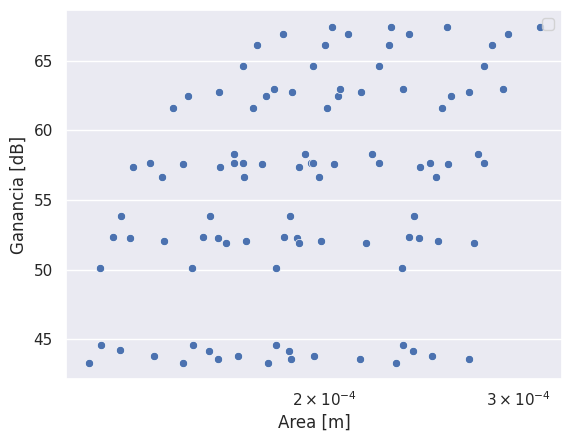

In [133]:
sns.scatterplot(data=ota_df_new, x="area", y="gain")
plt.xlabel(r"Area [m]")
plt.ylabel(r"Ganancia [dB]")
plt.locator_params(axis='x', nbins=10) 
plt.legend(loc = 'upper right')
plt.xscale("log")
plt.xscale("log")

plt.savefig('gain_topo2.pdf')

/tmp/ipykernel_4014/4192085568.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc = 'upper right')
/tmp/ipykernel_4014/4192085568.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')
/tmp/ipykernel_4014/4192085568.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc = 'upper right')


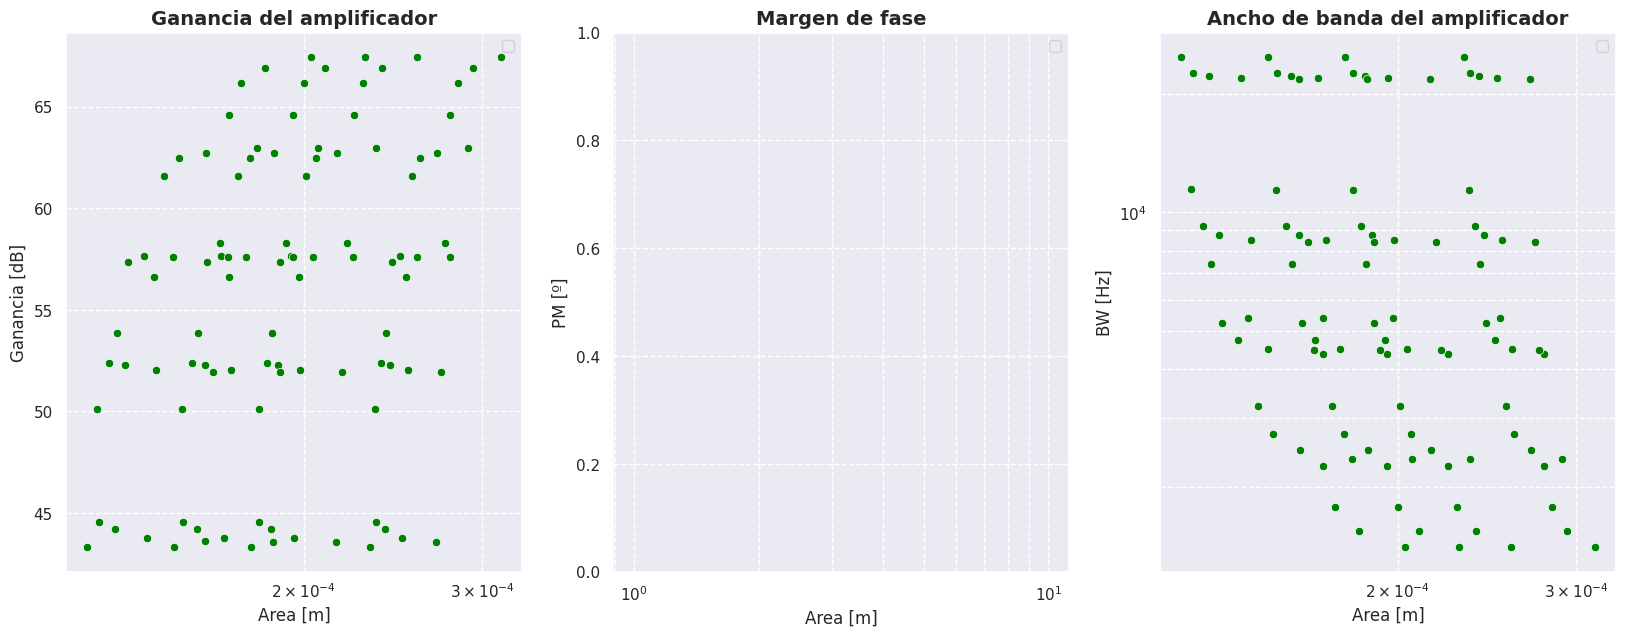

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
#sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare')
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
#sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
#sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
#sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('fullcc_ota_explore_raw_SKY.pdf')

In [128]:
OTA_primitive_wc = Primitive(
    parameters={
        Symbol("Ra"): ota_df_wc_new["rout_OTA"],
        Symbol("gma"): ota_df_wc_new["gm_OTA"],
    }
)

OTA_primitive_wc.outputs = {
    Symbol("W_diff_m1"): ota_df_wc_new[Symbol("W_diff_m1")].values,
    Symbol("L_diff_m1"): ota_df_wc_new[Symbol("L_diff_m1")].values,
    Symbol("W_diff_m2"): ota_df_wc_new[Symbol("W_diff_m2")].values,
    Symbol("L_diff_m2"): ota_df_wc_new[Symbol("L_diff_m2")].values,

    Symbol("W_aload"): ota_df_wc_new[Symbol("W_aload")].values,
    Symbol("L_aload"): ota_df_wc_new[Symbol("L_aload")].values,

    Symbol("W_cs"): ota_df_wc_new[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_wc_new[Symbol("L_cs")].values,
}

In [129]:
pt_2_wc = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.001543295686831]),
        Symbol('Ro_pt'): np.asarray([90994.8023538388]),
        Symbol("Cgg_pt"): np.asarray([1.0210799490783093e-12]),
        Symbol("Cgd_pt"): np.asarray([1.0190197779098047e-15]),
        Symbol("Cin_pt"): np.asarray([1.1641828183581444e-12]),
        Symbol("dropout"): np.asarray([0.0971945954880531]),
        Symbol('Vota'): np.asarray([1.057873324243474])
    }
)

pt_2_wc.outputs = {
    Symbol("W_pt"): np.asarray([0.0009077961345068]),
    Symbol("L_pt"): np.asarray([4e-7])
}

In [130]:
Cc_primitive_LDO_2 = Primitive(
    parameters={
        Symbol("Cc"): np.asarray([3.1622776601683798e-12, 1e-12, 3.1622e-12, 1e-12]),
        Symbol("Rc"): np.asarray([1000.0, 1000, 3162, 3162])
    }
)

Cc_primitive_LDO_2.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive_LDO_2.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive_LDO_2.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive_LDO_2.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, 4)
}

In [137]:
LDO_macro.ext_mask = None

LDO_macro.primitives = [OTA_primitive_wc, pt_2_wc, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df_wc, ldo_df_wc_mask = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  LDO_macro
Netlist:  ldo
Running MNA... 
MNA of psrr_LDO took: 0.03568124771118164
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
MNA of dc_LDO took: 0.020733356475830078
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
MNA of gain_ol_LDO took: 0.02179098129272461
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
MNA of phase_margin_LDO took: 0.02410578727722168
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <fun

In [139]:
OTA_primitive = Primitive(
    parameters={
        Symbol("Ra"): ota_df_new["rout_OTA"],
        Symbol("gma"): ota_df_new["gm_OTA"],
    }
)

OTA_primitive.outputs = {
    Symbol("W_diff_m1"): ota_df_new[Symbol("W_diff_m1")].values,
    Symbol("L_diff_m1"): ota_df_new[Symbol("L_diff_m1")].values,
    Symbol("W_diff_m2"): ota_df_new[Symbol("W_diff_m2")].values,
    Symbol("L_diff_m2"): ota_df_new[Symbol("L_diff_m2")].values,

    Symbol("W_aload"): ota_df_new[Symbol("W_aload")].values,
    Symbol("L_aload"): ota_df_new[Symbol("L_aload")].values,

    Symbol("W_cs"): ota_df_new[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_new[Symbol("L_cs")].values,
}

In [140]:
pt_2 = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.0266634512908571]),
        Symbol('Ro_pt'): np.asarray([1767.5635905016463]),
        Symbol("Cgg_pt"): np.asarray([1.2022408576105078e-12]),
        Symbol("Cgd_pt"): np.asarray([2.2391190852909668e-15]),
        Symbol("Cin_pt"): np.asarray([1.3077690750420409e-12]),
        Symbol("dropout"): np.asarray([0.3806709000001225]),
        Symbol('Vota'): np.asarray([0.6888888888888889])
    }
)

pt_2.outputs = {
    Symbol("W_pt"): np.asarray([0.0009077961345068]),
    Symbol("L_pt"): np.asarray([4e-7])
}

In [141]:
LDO_macro.ext_mask = ldo_df_wc_mask

LDO_macro.primitives = [OTA_primitive, pt_2, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_ol
Netlist:  ldo
Running MNA... 
MNA of psrr_LDO took: 0.030177831649780273
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
MNA of dc_LDO took: 0.021669387817382812
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
MNA of gain_ol_LDO took: 0.020855426788330078
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
MNA of phase_margin_LDO took: 0.018847942352294922
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <fun

In [142]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["psrr_wc"] = 20*np.log10(ldo_df_wc["psrr_LDO"])

ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df['gain_ol_wc'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

ldo_df["Vota_wc"] = ldo_df_wc[Symbol("Vota")]
ldo_df["cin_pt_wc"] = ldo_df_wc[Symbol("Cin_pt")]

ldo_df['gmid'] = ldo_df[Symbol('gm_pt')]/pt.inputs['il']

ldo_df["phase_margin_LDO_wc"] = ldo_df_wc["phase_margin_LDO"]

ldo_df['loadreg'] = np.abs(ldo_df['dc_LDO']-ldo_df_wc['dc_LDO'])/IL

ldo_df["bw"] = 1/(2*np.pi*ldo_df[Symbol("Ra")]*(ldo_df[Symbol("Cin_pt")]+ldo_df[Symbol("gm_pt")]*ldo_df[Symbol("Ro_pt")]*ldo_df[Symbol("Cc")]))    
ldo_df["gain_ota"] = 20*np.log10(ldo_df[Symbol("Ra")]*ldo_df[Symbol("gma")])

#ldo_df = ldo_df[(ldo_df["gain_ota"]>20) & (ldo_df[Symbol("W_pt")]<0.6e-3) & (ldo_df[Symbol("dropout")]<0.4)]

ldo_df_new = ldo_df[((ldo_df[Symbol("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df[Symbol("W_pt")]<1e-3)  & (ldo_df["bw"]>100)  & (ldo_df["loadreg"]<1))]
#ldo_df_new = ldo_df
ldo_df_new.sort_values(by="area")

,Ra,gma,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,Cin_pt,dropout,Vota,Cc,...,psrr_wc,gain_ol,gain_ol_wc,Vota_wc,cin_pt_wc,gmid,phase_margin_LDO_wc,loadreg,bw,gain_ota
289,1.314968e+07,0.000104,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-57.845659,77.637643,51.596993,1.057873,1.164183e-12,5.253882,89.898890,0.693416,249.877246,62.734938
291,1.314968e+07,0.000104,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-57.845659,77.637643,51.596993,1.057873,1.164183e-12,5.253882,91.023290,0.693416,249.877246,62.734938
337,1.442640e+07,0.000118,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-62.567664,79.499316,56.331767,1.057873,1.164183e-12,5.253882,89.806900,0.474121,227.763355,64.596611
339,1.442640e+07,0.000118,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-62.567664,79.499316,56.331767,1.057873,1.164183e-12,5.253882,91.062674,0.474121,227.763355,64.596611
353,1.835839e+07,0.000110,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-62.441556,81.042937,56.205401,1.057873,1.164183e-12,5.253882,89.816052,0.435844,178.981149,66.140232
355,1.835839e+07,0.000110,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-62.441556,81.042937,56.205401,1.057873,1.164183e-12,5.253882,91.026406,0.435844,178.981149,66.140232
305,1.391093e+07,0.000101,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-57.676548,77.880652,51.427283,1.057873,1.164183e-12,5.253882,89.912330,0.692132,236.203214,62.977947
307,1.391093e+07,0.000101,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-57.676548,77.880652,51.427283,1.057873,1.164183e-12,5.253882,90.996046,0.692132,236.203214,62.977947
369,2.118987e+07,0.000104,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-62.152552,81.783757,55.915790,1.057873,1.164183e-12,5.253882,89.839753,0.425933,155.064961,66.881052
371,2.118987e+07,0.000104,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-62.152552,81.783757,55.915790,1.057873,1.164183e-12,5.253882,90.964121,0.425933,155.064961,66.881052


In [143]:
pareto_dict = {"area": ldo_df_new["area"].values, "pm": ldo_df_new["phase_margin_LDO_wc"].values}
pareto_df = pd.DataFrame(pareto_dict)

mask = pareto.paretoset(pareto_df, sense=["min", "max"])

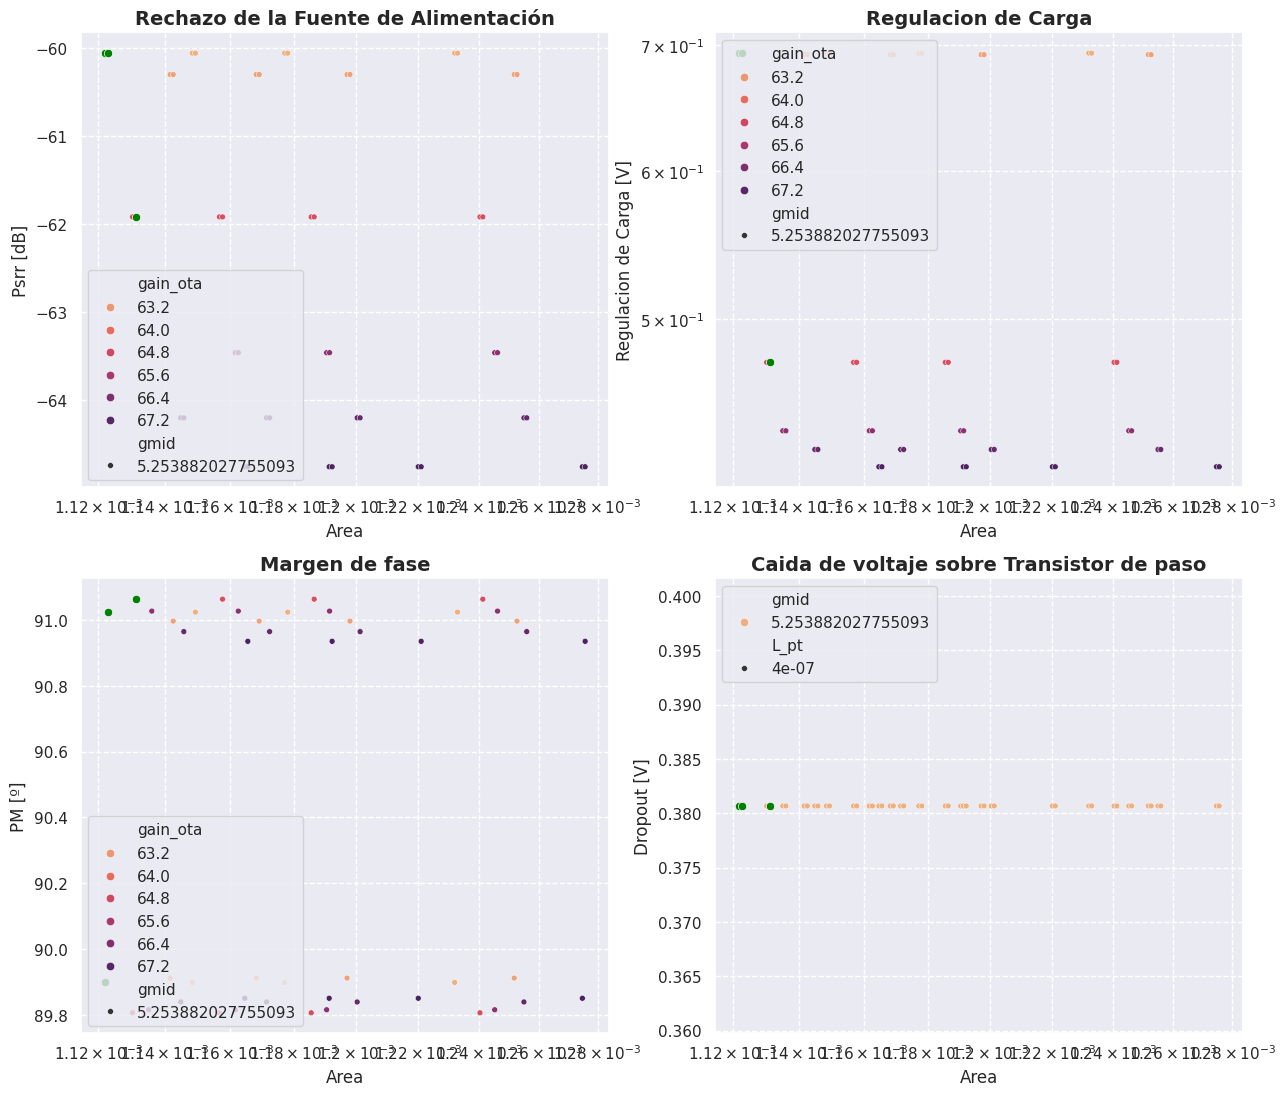

In [144]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
sns.scatterplot(ax=axs[0,0], data=ldo_df_new[mask], x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new[mask], x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=Symbol('dropout'), palette='flare', hue='gmid', rasterized=True, size=Symbol('L_pt'))
sns.scatterplot(ax=axs[1,1], data=ldo_df_new[mask], x='area', y=Symbol('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new[mask], x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Area")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulacion de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Area")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Area")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Area")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "lower left")
sns.move_legend(axs[0,1], "upper left")
sns.move_legend(axs[1,0], "lower left")
sns.move_legend(axs[1,1], "upper left")

plt.savefig('ldo_explore_raw.pdf')

In [145]:
ldo_df_new[mask].to_csv("data/GF_lv_ldo_final_98_10_10_ccdiff.csv")